# Customer retention

In this notebook, we will generate features that indicate customer retention for merchants.

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Customer Retention")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "8g") 
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("OFF")

Read all data.

In [19]:
all_data_sdf = spark.read.parquet("../data/curated/fraud_watch/")
all_data_sdf.printSchema()
print(all_data_sdf.count())
all_data_sdf.limit(5)

root
 |-- merchant_abn: long (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- consumer_fraud: double (nullable = true)
 |-- merchant_fraud: double (nullable = true)

14195505


merchant_abn,order_datetime,user_id,dollar_value,order_id,postcode,consumer_fraud,merchant_fraud
80788167198,2021-08-20,44,158.88701712957197,360a891b-8271-461...,5074,0.0,0.0
37687523474,2021-08-20,44,14.31708123947184,5c77cc43-b0fd-432...,5074,0.0,0.0
43186523025,2021-08-19,44,56.782923459184794,e75d90e3-2656-4dc...,5074,0.0,0.0
33233265647,2021-08-15,44,26.557524640642136,a9f754e4-af51-463...,5074,0.0,0.0
70172340121,2021-07-15,44,139.3475757940659,71753d60-5634-422...,5074,0.0,0.0


## 1. Derive necessary information from merchant-customer relationship.
1. Calculate median transaction frequency between each customer and merchant.

In [20]:
from pyspark.sql import functions as F

# Step 1: Extract year and month from the 'order_datetime' field
all_data_sdf = all_data_sdf.withColumn("year_month", F.date_format("order_datetime", "yyyy-MM"))

# Step 2: Group by 'merchant_abn', 'user_id', and 'year_month' to get monthly transaction counts
monthly_trans_count = all_data_sdf.groupBy("merchant_abn", "user_id", "year_month") \
    .agg(F.count("order_id").alias("monthly_count"))

# Step 3: Calculate the median transaction frequency for each 'merchant_abn' and 'user_id'
# We use approx_percentile to get the median (50th percentile)
median_trans_freq_sdf = monthly_trans_count.groupBy("merchant_abn", "user_id") \
    .agg(F.expr('percentile_approx(monthly_count, 0.5)').alias('median_transaction_frequency'))

# Step 4: Show the new dataframe with unique merchant_abn, user_id, and median_transaction_frequency
median_trans_freq_sdf.show()


+------------+-------+----------------------------+
|merchant_abn|user_id|median_transaction_frequency|
+------------+-------+----------------------------+
| 10023283211|      8|                           1|
| 10023283211|     92|                           1|
| 10023283211|    101|                           1|
| 10023283211|    146|                           1|
| 10023283211|    161|                           1|
| 10023283211|    173|                           1|
| 10023283211|    202|                           1|
| 10023283211|    203|                           1|
| 10023283211|    272|                           1|
| 10023283211|    286|                           1|
| 10023283211|    305|                           1|
| 10023283211|    343|                           1|
| 10023283211|    420|                           1|
| 10023283211|    498|                           1|
| 10023283211|    550|                           1|
| 10023283211|    607|                           1|
| 1002328321

In [21]:
median_trans_freq_sdf.count()

8516030

2. Generate a boolean field that indicates whether a customer is a returning customer for a certain merchant.
Returning customer is defined by having more than one transaction with the same merchant.

In [22]:
from pyspark.sql import functions as F

# Step 1: Group by 'merchant_abn' and 'user_id' to count transactions
customer_transaction_count = all_data_sdf.groupBy("merchant_abn", "user_id") \
    .agg(F.count("order_id").alias("transaction_count"))

# Step 2: Create a boolean column indicating if the customer is returning (more than 1 transaction)
returning_customer_sdf = customer_transaction_count.withColumn(
    "is_returning_customer", F.when(F.col("transaction_count") > 1, True).otherwise(False)
)

# Step 3: Show the resulting DataFrame
returning_customer_sdf.select("merchant_abn", "user_id", "is_returning_customer").show()

returning_customer_sdf.show()

+------------+-------+---------------------+
|merchant_abn|user_id|is_returning_customer|
+------------+-------+---------------------+
| 20985347699|     44|                 true|
| 21772962346|     61|                false|
| 54272781746|     61|                false|
| 72539760068|     61|                false|
| 32530636640|    105|                 true|
| 59162205130|    123|                false|
| 67920961191|    127|                false|
| 72231375027|    131|                false|
| 94455880010|    132|                false|
| 78963299452|    132|                false|
| 76819856970|    156|                false|
| 38603393734|    156|                false|
| 60956456424|    160|                 true|
| 96152467973|    160|                 true|
| 90087872851|    210|                false|
| 87630626808|    218|                false|
| 32361057556|    218|                 true|
| 76646764782|    218|                false|
| 74648589246|    218|                false|
| 62773208

+------------+-------+-----------------+---------------------+
|merchant_abn|user_id|transaction_count|is_returning_customer|
+------------+-------+-----------------+---------------------+
| 20985347699|     44|                5|                 true|
| 21772962346|     61|                1|                false|
| 54272781746|     61|                1|                false|
| 72539760068|     61|                1|                false|
| 32530636640|    105|                2|                 true|
| 59162205130|    123|                1|                false|
| 67920961191|    127|                1|                false|
| 72231375027|    131|                1|                false|
| 94455880010|    132|                1|                false|
| 78963299452|    132|                1|                false|
| 76819856970|    156|                1|                false|
| 38603393734|    156|                1|                false|
| 60956456424|    160|                2|               

In [23]:
returning_customer_sdf.count()

8516030

3. Find median transaction value between each merchant and customer.

In [24]:
from pyspark.sql import functions as F

# Step 1: Group by 'merchant_abn' and 'user_id', then calculate the median transaction value
median_transaction_value_sdf = all_data_sdf.groupBy("merchant_abn", "user_id") \
    .agg(F.expr('percentile_approx(dollar_value, 0.5)').alias('median_transaction_value'))

# Step 2: Show the resulting DataFrame with merchant_abn, user_id, and median transaction value
median_transaction_value_sdf.show()


+------------+-------+------------------------+
|merchant_abn|user_id|median_transaction_value|
+------------+-------+------------------------+
| 10023283211|      8|       136.7615502894258|
| 10023283211|     92|       177.5094366501849|
| 10023283211|    101|      483.59840138297426|
| 10023283211|    146|       431.8016693626082|
| 10023283211|    161|       521.6673071603941|
| 10023283211|    202|      284.28664583466747|
| 10023283211|    203|      166.81817823131036|
| 10023283211|    272|      133.66493133608301|
| 10023283211|    286|      132.59732196566966|
| 10023283211|    305|      371.08447815885035|
| 10023283211|    343|       105.5363273968829|
| 10023283211|    420|       160.8661966406608|
| 10023283211|    498|       553.1415762513716|
| 10023283211|    550|       199.6245878601543|
| 10023283211|    607|       152.5873079647273|
| 10023283211|    631|       277.9883720791882|
| 10023283211|    663|      278.50462723411687|
| 10023283211|    664|      163.55448992

Now join these new columns together, on key (merchant_abn, user_id).

In [25]:
from pyspark.sql import functions as F

# Using the following dataframes:
# 1. median_trans_freq_sdf: Contains 'merchant_abn', 'user_id', and 'median_transaction_frequency'
# 2. median_transaction_value_sdf: Contains 'merchant_abn', 'user_id', and 'median_transaction_value'
# 3. returning_customer_sdf: Contains 'merchant_abn', 'user_id', and 'is_returning_customer'

# Step 1: Join median transaction frequency with median transaction value
merchant_customer_sdf = median_trans_freq_sdf.join(
    median_transaction_value_sdf,
    on=["merchant_abn", "user_id"],
    how="left"
)

# Step 2: Join the result with the returning customer DataFrame
merchant_customer_sdf = merchant_customer_sdf.join(
    returning_customer_sdf,
    on=["merchant_abn", "user_id"],
    how="left"
)

# Step 3: Show the final result
merchant_customer_sdf.show()


+------------+-------+----------------------------+------------------------+-----------------+---------------------+
|merchant_abn|user_id|median_transaction_frequency|median_transaction_value|transaction_count|is_returning_customer|
+------------+-------+----------------------------+------------------------+-----------------+---------------------+
| 10023283211|     92|                           1|       177.5094366501849|                1|                false|
| 10023283211|    101|                           1|      483.59840138297426|                1|                false|
| 10023283211|    161|                           1|       521.6673071603941|                1|                false|
| 10023283211|    272|                           1|      133.66493133608301|                1|                false|
| 10023283211|    286|                           1|      132.59732196566966|                1|                false|
| 10023283211|    343|                           1|       105.53

Now we have information for merchant-customer relationship on:
1. median_transaction_frequency
2. is_returning_customer
3. median_transaction_value

Do some visualisation to check for reasonableness.

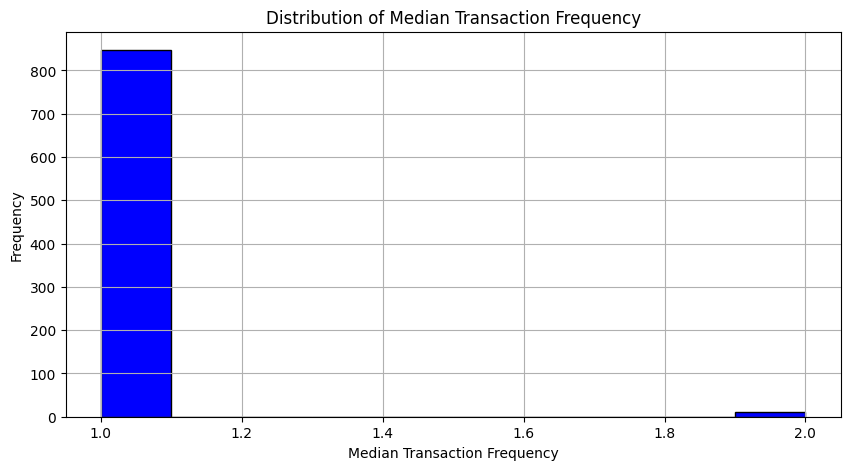

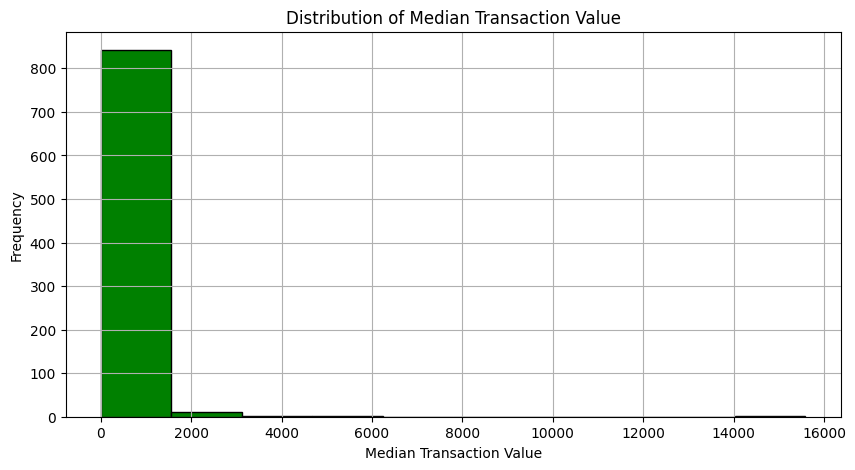

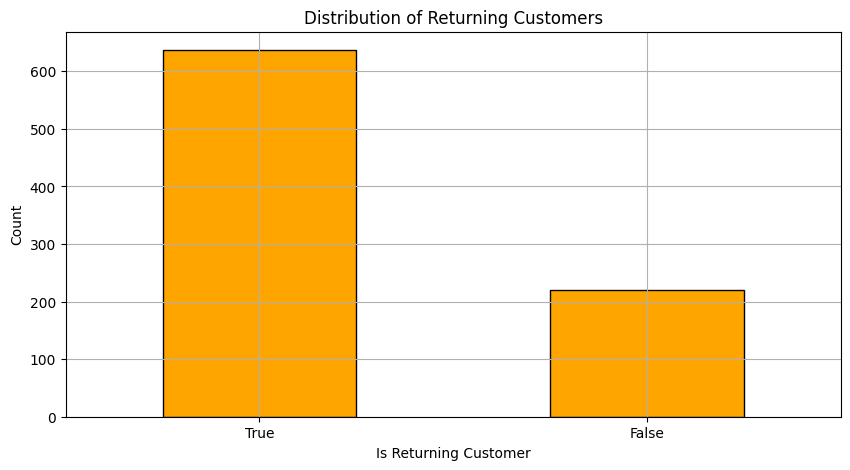

In [26]:
# This cell takes a while to run. 

# Step 1: Take a 1% sample of the Spark DataFrame (without replacement)
merchant_customer_sample_sdf = merchant_customer_sdf.sample(fraction=0.0001, seed=42)

# Step 2: Convert the sampled Spark DataFrame to Pandas DataFrame
merchant_customer_pdf = merchant_customer_sample_sdf.toPandas()

# Step 3: Visualize distributions using the Pandas DataFrame

# Median Transaction Frequency Distribution
plt.figure(figsize=(10, 5))
plt.hist(merchant_customer_pdf['median_transaction_frequency'], bins=10, color='blue', edgecolor='black')
plt.title('Distribution of Median Transaction Frequency')
plt.xlabel('Median Transaction Frequency')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Median Transaction Value Distribution
plt.figure(figsize=(10, 5))
plt.hist(merchant_customer_pdf['median_transaction_value'], bins=10, color='green', edgecolor='black')
plt.title('Distribution of Median Transaction Value')
plt.xlabel('Median Transaction Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Is Returning Customer Distribution (Boolean Distribution)
plt.figure(figsize=(10, 5))
merchant_customer_pdf['is_returning_customer'].value_counts().plot(kind='bar', color='orange', edgecolor='black')
plt.title('Distribution of Returning Customers')
plt.xlabel('Is Returning Customer')
plt.ylabel('Count')
plt.xticks([0, 1], ['True', 'False'], rotation=0)
plt.grid(True)
plt.show()


## 2. Aggregate information by merchant

1. Count number of customers per merchant.
2. Find proprotion of returning customers per merchant.
3. Find median of median monthly customer transaction frequencies.
4. Find median of median customer transaction value.

In [27]:
from pyspark.sql import functions as F

# Calculate number of customers, returning customer proportion, and medians
merchant_aggregated_sdf = merchant_customer_sdf.groupBy("merchant_abn").agg(
    # Number of unique customers
    F.countDistinct("user_id").alias("number_of_customers"),
    
    # Returning customer proportion
    (F.sum(F.when(F.col("is_returning_customer") == True, 1).otherwise(0)) / 
     F.countDistinct("user_id")).alias("returning_customer_proportion"),
)

# Show the result
merchant_aggregated_sdf.show()
merchant_aggregated_sdf.count()


+------------+-------------------+-----------------------------+
|merchant_abn|number_of_customers|returning_customer_proportion|
+------------+-------------------+-----------------------------+
| 12516851436|                210|                          0.0|
| 15613631617|               1714|         0.039089848308051345|
| 19839532017|                714|          0.01680672268907563|
| 24406529929|               3826|          0.08651332984840565|
| 28767881738|                  4|                          0.0|
| 34440496342|                215|                          0.0|
| 35344855546|               1477|          0.03046716316858497|
| 37935728745|                 14|                          0.0|
| 38700038932|               6170|            0.139870340356564|
| 38986645707|                 42|                          0.0|
| 41956465747|                278|         0.003597122302158...|
| 48214071373|                535|         0.009345794392523364|
| 52763133264|           

4422

In [29]:
merchant_aggregated_sdf.write.parquet("../data/curated/customer_retention/")

In [13]:
merchant_two_aggregated_sdf = merchant_customer_sdf.groupBy("merchant_abn").agg(
    # Median transaction frequency
    F.expr('percentile_approx(median_transaction_frequency, 0.5)').alias('median_transaction_frequency'),
    
    # Median transaction value
    F.expr('percentile_approx(median_transaction_value, 0.5)').alias('median_transaction_value'),
)
merchant_two_aggregated_sdf.show()

+------------+----------------------------+------------------------+
|merchant_abn|median_transaction_frequency|median_transaction_value|
+------------+----------------------------+------------------------+
| 10023283211|                           1|      178.11716932508506|
| 10323485998|                           1|       92.82797065210569|
| 10342410215|                           1|        317.875081131046|
| 10346855916|                           1|      1823.1077727510717|
| 10385163239|                           1|      305.48250363857954|
| 10648956813|                           1|       59.45392193903542|
| 10672322914|                           1|      3836.7974948713386|
| 10714068705|                           1|       96.71305150845842|
| 10930486968|                           1|        98.3588156585886|
| 11024352823|                           1|       191.3462831350267|
| 11076688542|                           1|       717.8094945703767|
| 11121775571|                    

In [16]:
merchant_aggregated_sdf.show()

ERROR:root:KeyboardInterrupt while sending command.                             
Traceback (most recent call last):
  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/python/3.12.1/lib/python3.12/socket.py", line 707, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 